In [10]:
from __future__ import annotations

import os
from pathlib import Path
import json
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    average_precision_score, roc_auc_score, precision_recall_curve,
    roc_curve, confusion_matrix, classification_report
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV

import plotly.express as px
import plotly.graph_objects as go

import joblib
import openml

ROOT = Path("/Users/rhishabhpatil/Desktop/Portfolio/Fraud_Dashboard")
OUT = ROOT / "outputs"
(OUT / "data").mkdir(parents=True, exist_ok=True)
(OUT / "models").mkdir(parents=True, exist_ok=True)
(OUT / "metrics").mkdir(parents=True, exist_ok=True)
(OUT / "figures").mkdir(parents=True, exist_ok=True)

np.random.seed(42)

In [12]:
def load_openml_creditcard(dataset_id: int = 42175) -> pd.DataFrame:
    ds = openml.datasets.get_dataset(dataset_id)
    X, y, *_ = ds.get_data(dataset_format="dataframe", target=ds.default_target_attribute)
    df = X.copy()
    df["Class"] = y.astype(int)
    return df

df = load_openml_creditcard(42175)
df.to_parquet(OUT / "data" / "raw_creditcard.parquet", index=False)

df.shape, df["Class"].value_counts().to_dict()


((284807, 31), {0: 284315, 1: 492})

In [14]:
kpis = {
    "rows": int(df.shape[0]),
    "cols": int(df.shape[1]),
    "fraud_rate": float(df["Class"].mean()),
    "fraud_count": int(df["Class"].sum()),
}
kpis


{'rows': 284807,
 'cols': 31,
 'fraud_rate': 0.001727485630620034,
 'fraud_count': 492}

In [16]:
X = df.drop(columns=["Class"])
y = df["Class"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

base_model = HistGradientBoostingClassifier(
    max_depth=6,
    learning_rate=0.05,
    max_iter=400,
    random_state=42
)

# Calibrate so probabilities behave better for thresholding
model = CalibratedClassifierCV(base_model, method="isotonic", cv=3)
model.fit(X_train, y_train)

proba = model.predict_proba(X_test)[:, 1]

pr_auc = average_precision_score(y_test, proba)
roc_auc = roc_auc_score(y_test, proba)

metrics = {"pr_auc": float(pr_auc), "roc_auc": float(roc_auc)}
metrics


{'pr_auc': 0.815211571613939, 'roc_auc': 0.9805211934239088}

In [18]:
precision, recall, thr = precision_recall_curve(y_test, proba)
thr = np.append(thr, 1.0)

f1 = (2 * precision * recall) / (precision + recall + 1e-12)
best_i = int(np.nanargmax(f1))
best_thr = float(thr[best_i])

best_thr, float(f1[best_i]), float(precision[best_i]), float(recall[best_i])


(0.2908541169145505,
 0.8124999999995002,
 0.8297872340425532,
 0.7959183673469388)

In [20]:
def pick_threshold_by_cost(y_true, p, cost_fp=1.0, cost_fn=25.0):
    # cost_fn >> cost_fp because missing fraud is expensive
    candidates = np.linspace(0.001, 0.999, 500)
    best = (None, float("inf"))
    for t in candidates:
        pred = (p >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, pred).ravel()
        cost = fp * cost_fp + fn * cost_fn
        if cost < best[1]:
            best = (t, cost)
    return float(best[0]), float(best[1])

cost_thr, cost_val = pick_threshold_by_cost(y_test.values, proba, cost_fp=1.0, cost_fn=40.0)
cost_thr, cost_val


(0.08700000000000001, 573.0)

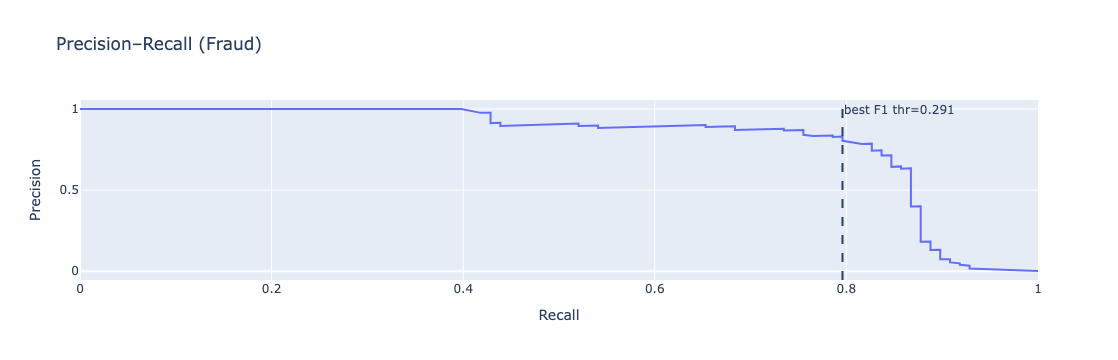

In [22]:
fig_pr = go.Figure()
fig_pr.add_trace(go.Scatter(x=recall, y=precision, mode="lines", name="PR curve"))
fig_pr.add_vline(x=float(recall[best_i]), line_dash="dash", annotation_text=f"best F1 thr={best_thr:.3f}")
fig_pr.update_layout(title="Precision–Recall (Fraud)", xaxis_title="Recall", yaxis_title="Precision")
fig_pr.write_html(OUT / "figures" / "pr_curve.html")
fig_pr


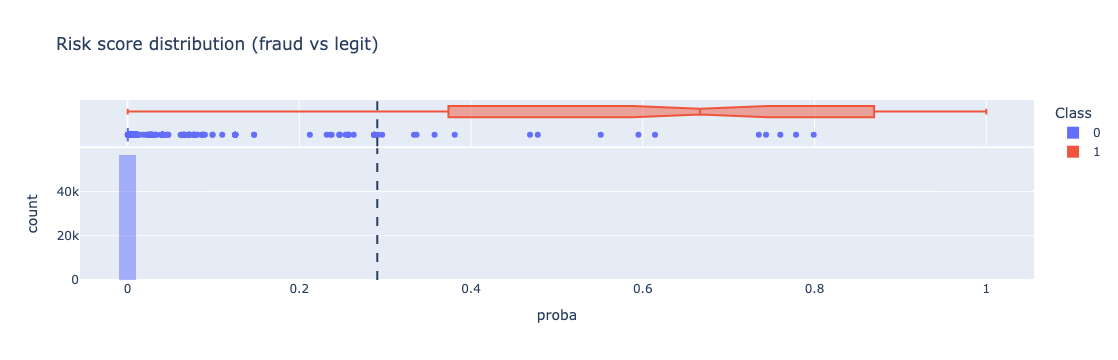

In [24]:
tmp = pd.DataFrame({"proba": proba, "Class": y_test.values})
fig_dist = px.histogram(
    tmp, x="proba", color="Class", nbins=60,
    barmode="overlay", marginal="box",
    title="Risk score distribution (fraud vs legit)"
)
fig_dist.add_vline(x=best_thr, line_dash="dash")
fig_dist.write_html(OUT / "figures" / "score_distribution.html")
fig_dist


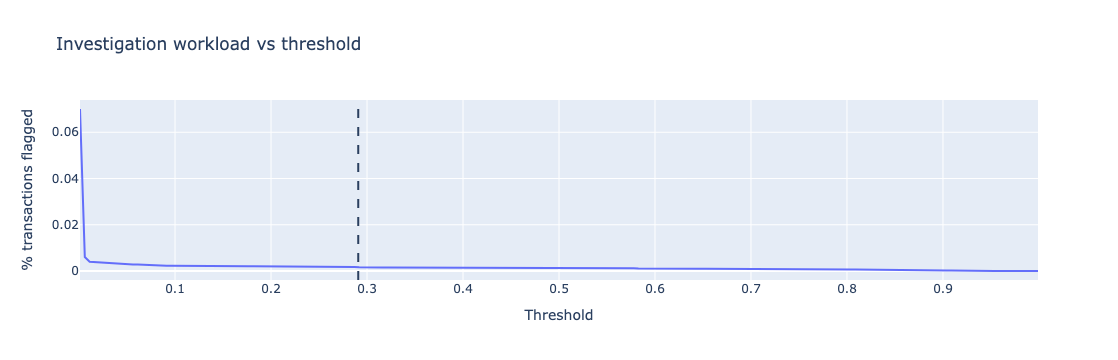

In [26]:
thresholds = np.linspace(0.001, 0.999, 200)
workload = [(proba >= t).mean() for t in thresholds]  # % flagged
fig_work = px.line(
    x=thresholds, y=workload,
    labels={"x": "Threshold", "y": "% transactions flagged"},
    title="Investigation workload vs threshold"
)
fig_work.add_vline(x=best_thr, line_dash="dash")
fig_work.write_html(OUT / "figures" / "workload_curve.html")
fig_work


In [28]:
pred = (proba >= best_thr).astype(int)
cm = confusion_matrix(y_test, pred)

report = classification_report(y_test, pred, output_dict=True)
payload = {
    **metrics,
    "best_threshold_f1": best_thr,
    "confusion_matrix": cm.tolist(),
    "classification_report": report
}

with open(OUT / "metrics" / "metrics.json", "w") as f:
    json.dump(payload, f, indent=2)

joblib.dump(model, OUT / "models" / "fraud_model.joblib")

payload


{'pr_auc': 0.815211571613939,
 'roc_auc': 0.9805211934239088,
 'best_threshold_f1': 0.2908541169145505,
 'confusion_matrix': [[56848, 16], [20, 78]],
 'classification_report': {'0': {'precision': 0.9996483083632272,
   'recall': 0.9997186268992684,
   'f1-score': 0.9996834663946822,
   'support': 56864.0},
  '1': {'precision': 0.8297872340425532,
   'recall': 0.7959183673469388,
   'f1-score': 0.8125,
   'support': 98.0},
  'accuracy': 0.9993679997191109,
  'macro avg': {'precision': 0.9147177712028902,
   'recall': 0.8978184971231036,
   'f1-score': 0.906091733197341,
   'support': 56962.0},
  'weighted avg': {'precision': 0.9993560716917018,
   'recall': 0.9993679997191109,
   'f1-score': 0.9993614274967033,
   'support': 56962.0}}}